## K-Means

### Using Clustering for Image Segmentation

In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os 

# For plotting 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
images_path = os.path.join(PROJECT_ROOT_DIR, "images")
filename = "ladybug.png"

In [4]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [19]:
from sklearn.cluster import KMeans

X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

/home/dlugano/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


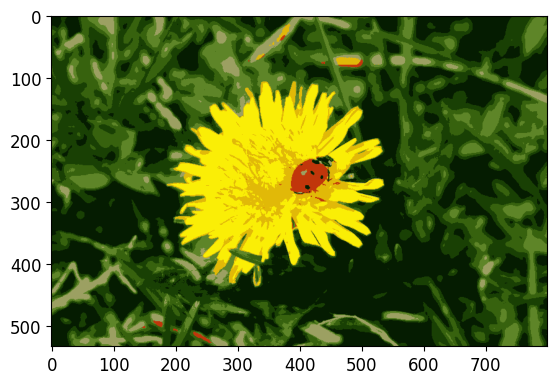

In [20]:
plt.imshow(segmented_img)
plt.show()

When
you use fewer than eight clusters, notice that the ladybug’s flashy red color
fails to get a cluster of its own: it gets merged with colors from the
environment. This is because K-Means prefers clusters of similar sizes. The
ladybug is small—much smaller than the rest of the image—so even though
its color is flashy, K-Means fails to dedicate a cluster to it.

### Using Clustering for Preprocessing

In [21]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [26]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [27]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Our baseline: 96.9% accuracy. Let’s see if we can do better by
using K-Means as a preprocessing step. We will create a pipeline that will
first cluster the training set into 50 clusters and replace the images with
their distances to these 50 clusters, then apply a Logistic Regression model:

In [29]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])

pipeline.fit(X_train, y_train)

/home/dlugano/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [30]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

how much did the error drop?

In [31]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

How about that? We reduced the error rate by over 35%! But we chose the number of clusters 
 completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for 
 is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of 
 is simply the one that results in the best classification performance.

In [ ]:
""" from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train) """